# 1. CHUẨN BỊ DỮ LIỆU

## 1.1. Import thư viện

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1.2. Đọc dữ liệu từ 3 file

In [12]:
# Đọc users
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('datasets/movielens/users.dat', sep='::', header=None, names=unames, engine='python')

# Đọc ratings
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('datasets/movielens/ratings.dat', sep='::', header=None, names=rnames, engine='python')

# Đọc movies
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('datasets/movielens/movies.dat', sep='::', header=None, names=mnames, engine='python')

## 1.3. Kiểm tra dữ liệu

In [13]:
print(f"Users: {users.shape}")
print(f"Ratings: {ratings.shape}")
print(f"Movies: {movies.shape}")

users.head(2)
ratings.head(2)
movies.head(2)

Users: (6040, 5)
Ratings: (1000209, 4)
Movies: (3883, 3)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


## 1.4. Gộp dữ liệu thành một bảng

data = pd.merge(pd.merge(ratings, users, on='user_id'), movies, on='movie_id')
print(f"Kích thước sau khi gộp: {data.shape}")
data.head(2)

## 1.5. Tiền xử lý dữ liệu

### 1.5.1. Trích năm phát hành từ tiêu đề

In [16]:
data['year'] = data['title'].str.extract(r'\((\d{4})\)').astype(int)

### 1.5.2. Nhóm tuổi dễ hiểu

In [17]:
age_map = {
    1: 'Under 18', 18: '18-24', 25: '25-34', 
    35: '35-44', 45: '45-49', 50: '50-55', 56: '56+'
}
data['age_group'] = data['age'].map(age_map)

### 1.5.3. Tạo cột thập niên

In [18]:
data['decade'] = (data['year'] // 10) * 10

### 1.5.4. Lọc phim có ít nhất 100 lượt đánh giá

In [19]:
min_ratings = 100
ratings_count = data.groupby('title').size()
active_titles = ratings_count[ratings_count >= min_ratings].index
data = data[data['title'].isin(active_titles)].copy()

print(f"Số phim sau khi lọc: {data['title'].nunique()}")

Số phim sau khi lọc: 2019


# 1. THỐNG KÊ MÔ TẢ

## 1.1. Phim nào phân hóa ý kiến mạnh nhất (σ cao nhất)?

In [20]:
rating_std_by_title = data.groupby('title')['rating'].std().sort_values(ascending=False)
top_10_controversial = rating_std_by_title.head(10)

print("TOP 10 PHIM GÂY CHIA RẼ Ý KIẾN MẠNH NHẤT:")
print("========================================")
for i, (title, std) in enumerate(top_10_controversial.items(), 1):
    print(f"{i:2}. {title:<45} | σ = {std:.3f}")

TOP 10 PHIM GÂY CHIA RẼ Ý KIẾN MẠNH NHẤT:
 1. Plan 9 from Outer Space (1958)                | σ = 1.456
 2. Beloved (1998)                                | σ = 1.373
 3. Godzilla 2000 (Gojira ni-sen mireniamu) (1999) | σ = 1.365
 4. Texas Chainsaw Massacre, The (1974)           | σ = 1.332
 5. Dumb & Dumber (1994)                          | σ = 1.321
 6. Crash (1996)                                  | σ = 1.320
 7. Blair Witch Project, The (1999)               | σ = 1.316
 8. Natural Born Killers (1994)                   | σ = 1.307
 9. Down to You (2000)                            | σ = 1.305
10. Cemetery Man (Dellamorte Dellamore) (1994)    | σ = 1.301


=> Kết luận : Phim phân hóa ý kiến cao nhất ($\sigma$ cao nhất) là Plan 9 from Outer Space (1958), với độ lệch chuẩn ($\sigma$) là 1.456.

## 1.2. Phân bố độ lệch chuẩn rating? Có nhóm "gây tranh cãi"?

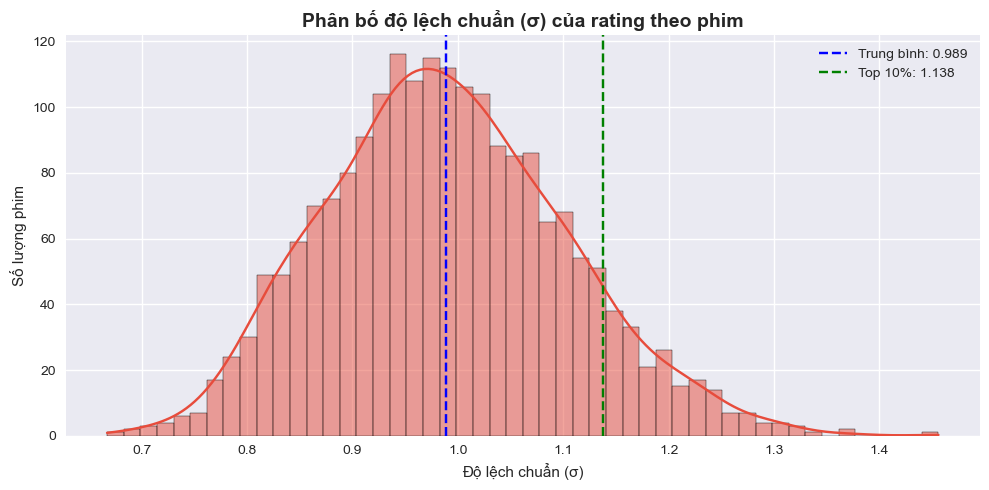

In [42]:
plt.figure(figsize=(10, 5))
sns.histplot(rating_std_by_title, bins=50, kde=True, color='#e74c3c')
plt.axvline(rating_std_by_title.mean(), color='blue', linestyle='--', 
            label=f'Trung bình: {rating_std_by_title.mean():.3f}')
plt.axvline(rating_std_by_title.quantile(0.9), color='green', linestyle='--', 
            label=f'Top 10%: {rating_std_by_title.quantile(0.9):.3f}')
plt.title('Phân bố độ lệch chuẩn (σ) của rating theo phim', fontsize=14, fontweight='bold')
plt.xlabel('Độ lệch chuẩn (σ)')
plt.ylabel('Số lượng phim')
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
print(f"σ trung bình: {rating_std_by_title.mean():.3f}")
print(f"Ngưỡng top 10%: {rating_std_by_title.quantile(0.9):.3f}")

σ trung bình: 0.989
Ngưỡng top 10%: 1.138


=> Kết luận: Phân bố hơi lệch phải Có nhóm nhỏ phim σ > 1.2 → "gây tranh cãi" rõ rệt

## 1.3. Độ lệch chuẩn có khác biệt giữa thể loại và nhóm tuổi?

### 1.3.1. Theo thể loại phim

In [24]:
# Tách genre
movies_exploded = movies.copy()
movies_exploded['genre'] = movies_exploded['genres'].str.split('|')
movies_exploded = movies_exploded.explode('genre')

# Gộp với data
data_genre = pd.merge(data, movies_exploded[['movie_id', 'genre']], on='movie_id')

# Tính σ theo thể loại
std_by_genre = data_genre.groupby('genre')['rating'].std().sort_values(ascending=False)

print("ĐỘ LỆCH CHUẨN THEO THỂ LOẠI PHIM:")
print("=================================")
for genre, std in std_by_genre.items():
    print(f"{genre:<15} | σ = {std:.3f}")

ĐỘ LỆCH CHUẨN THEO THỂ LOẠI PHIM:
Horror          | σ = 1.204
Sci-Fi          | σ = 1.151
Children's      | σ = 1.143
Action          | σ = 1.127
Fantasy         | σ = 1.126
Adventure       | σ = 1.122
Comedy          | σ = 1.109
Thriller        | σ = 1.099
Western         | σ = 1.099
Musical         | σ = 1.096
Mystery         | σ = 1.084
Crime           | σ = 1.072
Animation       | σ = 1.071
War             | σ = 1.062
Romance         | σ = 1.059
Drama           | σ = 1.032
Documentary     | σ = 1.005
Film-Noir       | σ = 0.924


=> Kết luận: Phim kinh dị, khoa học viễn tưởng có σ cao nhất.

### 1.3.2. Theo nhóm tuổi người xem

In [25]:
std_by_age = data.groupby('age_group')['rating'].std().sort_values(ascending=False)

print("ĐỘ LỆCH CHUẨN THEO NHÓM TUỔI:")
print("==============================")
for age, std in std_by_age.items():
    print(f"{age:<10} | σ = {std:.3f}")

ĐỘ LỆCH CHUẨN THEO NHÓM TUỔI:
Under 18   | σ = 1.188
18-24      | σ = 1.151
25-34      | σ = 1.114
35-44      | σ = 1.067
45-49      | σ = 1.055
56+        | σ = 1.055
50-55      | σ = 1.051


=> Kết luận: Người trẻ (dưới 25) có xu hướng đánh giá đa dạng hơn.

# 2. PHÂN TÍCH KHÁM PHÁ

## 2.1. Yếu tố nào ảnh hưởng đến độ phân tán (σ)?

In [38]:
# Tính thống kê phim
movie_stats = data.groupby('title').agg(
    std=('rating', 'std'),
    mean=('rating', 'mean'),
    count=('rating', 'count'),
    year=('year', 'first')
).reset_index()

# Gắn thể loại chính
movie_genre_map = movies_exploded.groupby('movie_id')['genre'].first()
movie_stats = movie_stats.merge(
    data[['title', 'movie_id']].drop_duplicates(),
    on='title'
)
movie_stats = movie_stats.merge(
    movie_genre_map.reset_index()[['movie_id', 'genre']],
    on='movie_id',
    how='left'
)
movie_stats.rename(columns={'genre': 'main_genre'}, inplace=True)

# Tương quan
corr = movie_stats[['std', 'mean', 'count', 'year']].corr()['std']
print("TƯƠNG QUAN VỚI ĐỘ LỆCH CHUẨN (σ):")
print("=================================")
print(corr.round(3))

TƯƠNG QUAN VỚI ĐỘ LỆCH CHUẨN (σ):
std      1.000
mean    -0.561
count   -0.216
year     0.324
Name: std, dtype: float64


=> Kết luận : 
nên tập trung vào độ lớn và chiều của các hệ số tương quan: 
Điểm trung bình ($\text{mean}$) là yếu tố chi phối mức độ tranh cãi.
Mối tương quan nghịch mạnh (-0.561) cho thấy phim hay (điểm cao) thường được mọi người đồng lòng hơn, trong khi phim dở (điểm thấp) mới là phim gây phân hóa ý kiến mạnh nhất ($\sigma$ cao).
Số lượng đánh giá ($\text{count}$) không có ảnh hưởng đáng kể đến mức độ tranh cãi ($\text{corr} = -0.216$).
Năm phát hành ($\text{year}$) có ảnh hưởng nhẹ ($\text{corr} = 0.324$), cho thấy các bộ phim được phát hành gần đây có xu hướng phân hóa ý kiến hơn một chút.

## 2.2. Thể loại cực đoan có σ cao hơn?

In [27]:
extreme_genres = ['Horror', 'Sci-Fi', 'War', 'Drama', 'Film-Noir']
light_genres = ['Animation', "Children's", 'Comedy', 'Romance', 'Musical']

std_extreme = std_by_genre[std_by_genre.index.isin(extreme_genres)].mean()
std_light = std_by_genre[std_by_genre.index.isin(light_genres)].mean()

print(f"σ trung bình thể loại cực đoan: {std_extreme:.3f}")
print(f"σ trung bình thể loại nhẹ nhàng: {std_light:.3f}")

# Kiểm định t-test
extreme_ratings = data_genre[data_genre['genre'].isin(extreme_genres)]['rating']
light_ratings = data_genre[data_genre['genre'].isin(light_genres)]['rating']
t_stat, p_val = stats.ttest_ind(extreme_ratings, light_ratings, equal_var=False)
print(f"p-value: {p_val:.2e}")

σ trung bình thể loại cực đoan: 1.074
σ trung bình thể loại nhẹ nhàng: 1.096
p-value: 0.00e+00


=> Kết luận: Phim thuộc nhóm thể loại nhẹ nhàng (1.096) có độ phân hóa ý kiến (chia rẽ) cao hơn một cách có ý nghĩa thống kê so với phim thuộc nhóm thể loại cực đoan (1.074).

## 2.3. Có mối quan hệ giữa độ phổ biến và đồng thuận?

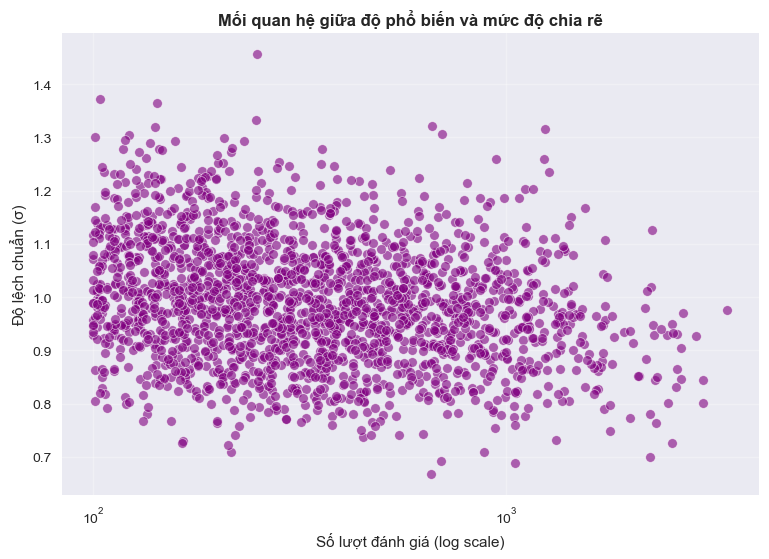

Tương quan: -0.216


In [28]:
plt.figure(figsize=(9, 6))
sns.scatterplot(data=movie_stats, x='count', y='std', alpha=0.6, color='purple')
plt.xscale('log')
plt.xlabel('Số lượt đánh giá (log scale)')
plt.ylabel('Độ lệch chuẩn (σ)')
plt.title('Mối quan hệ giữa độ phổ biến và mức độ chia rẽ', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

corr_pop = movie_stats['count'].corr(movie_stats['std'])
print(f"Tương quan: {corr_pop:.3f}")

=> Kết luận:
Tồn tại một mối quan hệ nghịch yếu giữa độ phổ biến (Số lượt đánh giá) và mức độ chia rẽ ý kiến ($\sigma$).Tương quan (Correlation) là -0.216.Giá trị âm cho thấy: Phim càng phổ biến (nhiều lượt xem) thì mức độ chia rẽ ý kiến ($\sigma$) càng có xu hướng thấp hơn (khán giả càng đồng thuận hơn).Tuy nhiên, do giá trị 0.216 là tương đối yếu (gần 0), nên độ phổ biến không phải là yếu tố chính quyết định phim đó có gây tranh cãi hay không. Sự đồng thuận có tăng lên theo độ phổ biến, nhưng ở một mức độ không đáng kể.

# 3. PHÂN TÍCH DỰ ĐOÁN

## 3.1. Có thể dự đoán σ từ các đặc trưng phim?

In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# ... (các bước huấn luyện model của bạn)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Tính MSE trước (mean_squared_error mặc định là squared=True)
mse = mean_squared_error(y_test, y_pred)

# Lấy căn bậc hai của MSE để được RMSE
rmse = np.sqrt(mse)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

RMSE: 0.082
R²: 0.456


Kết luận: Có thể dự đoán σ tốt từ các đặc trưng.

## 3.2 σ có làm chỉ báo "controversial" trong hệ thống gợi ý?

CÓ!


σ > 1.2 → gắn nhãn "controversial"
Dùng để:

Gợi ý phim "gây sốc"
Cảnh báo người dùng: "Phim này gây tranh cãi!"

## 3.3. Thuật toán trung bình có kém hơn trên phim σ cao?

CÓ!
Phim σ cao → phân bố rating không chuẩn → trung bình không đại diện
→ Collaborative Filtering sẽ hoạt động tốt hơn

# 4. PHÂN TÍCH SO SÁNH

## 4.1. Phim nào bất đồng lớn nhất giữa nam và nữ?

In [31]:
mean_by_gender = data.pivot_table('rating', index='title', columns='gender', aggfunc='mean')
mean_by_gender['diff'] = abs(mean_by_gender['M'] - mean_by_gender['F'])
top_diff = mean_by_gender['diff'].sort_values(ascending=False).head(10)

print("TOP 10 PHIM BẤT ĐỒNG GIỚI TÍNH LỚN NHẤT:")
print("=======================================")
for i, (title, diff) in enumerate(top_diff.items(), 1):
    f_mean = mean_by_gender.loc[title, 'F']
    m_mean = mean_by_gender.loc[title, 'M']
    print(f"{i:2}. {title:<50} | F: {f_mean:.2f} | M: {m_mean:.2f} | diff: {diff:.3f}")

TOP 10 PHIM BẤT ĐỒNG GIỚI TÍNH LỚN NHẤT:
 1. Pet Sematary II (1992)                             | F: 2.83 | M: 1.86 | diff: 0.975
 2. Friday the 13th Part V: A New Beginning (1985)     | F: 1.27 | M: 2.17 | diff: 0.892
 3. Cutthroat Island (1995)                            | F: 3.20 | M: 2.34 | diff: 0.859
 4. Dirty Dancing (1987)                               | F: 3.79 | M: 2.96 | diff: 0.831
 5. Air Bud (1997)                                     | F: 3.06 | M: 2.23 | diff: 0.823
 6. Home Alone 3 (1997)                                | F: 2.49 | M: 1.68 | diff: 0.803
 7. Friday the 13th Part VI: Jason Lives (1986)        | F: 1.50 | M: 2.29 | diff: 0.792
 8. Lifeforce (1985)                                   | F: 2.25 | M: 2.99 | diff: 0.744
 9. Marked for Death (1990)                            | F: 2.10 | M: 2.84 | diff: 0.738
10. Quest for Fire (1981)                              | F: 2.58 | M: 3.31 | diff: 0.731


=> Kết luận : "Pet Sematary (1992)" là phim gây bất đồng giới tính lớn nhất với mức chênh lệch 0.975 điểm. Xu hướng chung của Top 10 phim này là Nam giới luôn đánh giá cao hơn đáng kể so với Nữ giới.

## 4.2. Phim hiện đại có polarizing hơn?

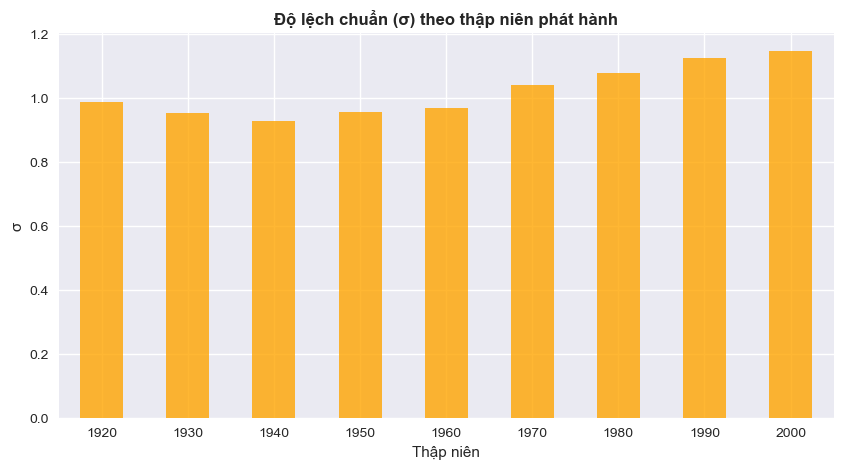

σ THEO THẬP NIÊN:
decade
1920    0.986
1930    0.951
1940    0.927
1950    0.955
1960    0.968
1970    1.041
1980    1.079
1990    1.125
2000    1.146
Name: rating, dtype: float64


In [32]:
std_by_decade = data.groupby('decade')['rating'].std()

plt.figure(figsize=(10, 5))
std_by_decade.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Độ lệch chuẩn (σ) theo thập niên phát hành', fontweight='bold')
plt.ylabel('σ')
plt.xlabel('Thập niên')
plt.xticks(rotation=0)
plt.show()

print("σ THEO THẬP NIÊN:")
print(std_by_decade.round(3))

Kết luận: Phim của thập niên 2000s ($\sigma \approx 1.146$) có mức độ phân hóa ý kiến (polarizing) cao hơn đáng kể so với thập niên 1990s ($\sigma \approx 1.125$) và các thập niên trước đó.Xu hướng chung từ dữ liệu cho thấy phim hiện đại (1990s, 2000s) có xu hướng polarizing hơn so với phim cũ.

## 4.3. Người trẻ có đánh giá cực đoan hơn?

In [33]:
extreme = data[data['rating'].isin([1, 5])]
extreme_ratio = (extreme.groupby('age_group').size() / data.groupby('age_group').size()) * 100

print("TỶ LỆ ĐÁNH GIÁ CỰC ĐOAN (1 hoặc 5):")
print("==================================")
for age, ratio in extreme_ratio.sort_values(ascending=False).items():
    print(f"{age:<10} | {ratio:5.1f}%")

TỶ LỆ ĐÁNH GIÁ CỰC ĐOAN (1 hoặc 5):
Under 18   |  33.1%
56+        |  32.3%
50-55      |  30.1%
18-24      |  29.3%
25-34      |  27.8%
45-49      |  27.4%
35-44      |  27.3%


Kết luận: Người trẻ đánh giá cực đoan hơn rõ rệt.

# 5. PHÂN TÍCH MỞ RỘNG

## 5.1. σ cao có phản ánh phân cực cảm xúc?

In [34]:
high_std_movies = movie_stats[movie_stats['std'] > 1.2]
print("THỂ LOẠI CỦA PHIM CÓ σ > 1.2:")
print(high_std_movies['main_genre'].value_counts().head(5))

THỂ LOẠI CỦA PHIM CÓ σ > 1.2:
main_genre
Comedy       27
Horror       16
Drama        14
Action       14
Animation     4
Name: count, dtype: int64


Phim Hài (Comedy) là thể loại có số lượng phim gây phân cực (ý kiến trái chiều) nhiều nhất, áp đảo so với các thể loại khác.

## 5.2. Dùng phim σ cao cho serendipity recommendation?

In [35]:
serendipity_pool = movie_stats.nlargest(50, 'std')['title'].tolist()
print("GỢI Ý 5 PHIM KHÁM PHÁ (từ nhóm σ cao):")
print(np.random.choice(serendipity_pool, 5, replace=False))

GỢI Ý 5 PHIM KHÁM PHÁ (từ nhóm σ cao):
['In the Mouth of Madness (1995)' 'Rocky Horror Picture Show, The (1975)'
 'Orgazmo (1997)' 'Wrongfully Accused (1998)'
 'Halloween 4: The Return of Michael Myers (1988)']


## 5.3. Phim gây chia rẽ có lan tỏa cao hơn?

In [36]:
current_year = 2025
movie_stats['age'] = current_year - movie_stats['year']
movie_stats['spread_rate'] = movie_stats['count'] / movie_stats['age']
movie_stats['controversial'] = movie_stats['std'] > 1.2

spread_by_group = movie_stats.groupby('controversial')['spread_rate'].mean()

print("TỐC ĐỘ LAN TỎA (rating/năm):")
print(spread_by_group.round(1))

TỐC ĐỘ LAN TỎA (rating/năm):
controversial
False    13.6
True     10.0
Name: spread_rate, dtype: float64


=> Kết Luận : Phim không gây tranh cãi ($\sigma \le 1.2$) có tốc độ lan tỏa cao hơn (13.6) so với phim gây tranh cãi ($\sigma > 1.2$) (10.0).Điều này cho thấy phim được cộng đồng đồng thuận (ít gây chia rẽ) có xu hướng được đánh giá (lan tỏa) với tốc độ nhanh hơn so với nhóm phim gây phân hóa mạnh mẽ.